In [1]:
cd ..

/home/mars/src_aiai


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tqdm
from scipy.special import iv, jv
import sparse


In [4]:
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op, NUFFT_op_1D, calculate_kaiser_bessel_coef, calculate_kaiser_bessel_coef_1d
from src.visualisation import compare

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [5]:
from src.data import load_M51

In [6]:
from skimage.transform import radon, iradon

In [7]:
m51 = load_M51() 
m51 /= m51.max()

In [8]:
class NUFFT_op_1D():
    """NUFFT implementation using a Kaiser-Bessel kernel for interpolation. 

    TODO integrate this function with its 2d variant
    """
    def __init__(self):
        pass
        # TODO generalise more, (pick axes, norm, etc.)
        
    def plan(self, uv, Nd, Kd, Jd, batch_size=None):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        if uv.ndim < 2:
            uv = uv[:,np.newaxis]
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_kaiser_bessel_coef_1d(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        # building sparse matrix
        indices = np.array(indices).reshape(-1, uv.shape[1] +2)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=[1, len(uv)] + list(Kd) )

        # calculating scaling based on iFT of the KB kernel
        J = Jd[0] 
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        # scaling done for both axes seperately
        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = sa # (sa.reshape(-1,1) * sa.reshape(1,-1))
    
    def dir_op(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0])))))  # why divide on both sides?

    
    def adj_op(self, k):
        kk = self._k2kk(k)
        xx = self._kk2xx(kk)
        xx = self._unpad(xx)
        xx = np.squeeze(xx) / self.scaling
        return xx 
        # return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0])).sum(axis=(2)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(kk, axes=(-1)), norm='ortho'), axes=(-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft(np.fft.fftshift(xx, axes=(-1)), norm='ortho'), axes=(-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            ] # remove zero padding from image


In [10]:
def forward(x):
    x = np.pad(x, (
            ( 0,0 ),
            ( (Kd[0]-Nd[0])//2, (Kd[0]-Nd[0])//2),
            ))
    rad = radon(x, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False)# N, M
    x_spokes = op_1d.dir_op(rad.T) # takes M, N
    return rad, x_spokes

def adjoint(y, filter_name='ramp'):
    x_spokes = op_1d.adj_op(y)  #op_1d.adj_op(y) # M, N
    rec = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False, filter_name=filter_name, output_size=256)   
    return x_spokes, rec

In [11]:
x, y = np.mgrid[:256,:256]
circle_mask = (x-128)**2 + (y-128)**2 < 128**2


In [12]:
n_spokes = 37
n_lenslets = 24
n_wavelengths = 10

Nd, Kd, Jd = (256,256), (512,512), (6,6)
uv = spider_sampling(n_spokes=n_spokes, n_lenslets=n_lenslets, n_wavelengths=n_wavelengths)
op = NUFFT_op()
op.plan(uv, Nd, Kd, Jd, batch_size=n_spokes)

100%|██████████| 4440/4440 [00:00<00:00, 5129.77it/s]


In [13]:
op_1d = NUFFT_op_1D()
uv_1d = uv[:n_lenslets//2*n_wavelengths,1] # 1 spoke has 120 measurements
# uv_1d = np.concatenate((-uv[:120,1][::-1], uv[:120,1]))
op_1d.plan(uv_1d.reshape(-1,1), [256], [512], [6])

100%|██████████| 120/120 [00:00<00:00, 13274.16it/s]


In [14]:
im = m51#*circle_mask
sin, ft = forward(im)
test, rec = adjoint(ft)

y = op.dir_op(im).reshape(-1, n_lenslets//2*n_wavelengths)
test2, rec2 = adjoint(y)

# 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann'
x_spokes = op_1d.adj_op(y)
rec3 = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=True, filter_name='ramp', output_size=256)   



/home/mars/.local/lib/python3.9/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


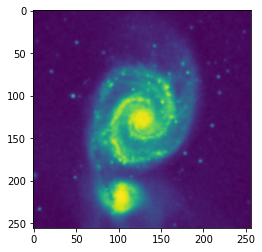

In [15]:
plt.imshow(im)

/tmp/ipykernel_129119/3536737689.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  titles=["True", f"NUFFT (PSNR: {peak_signal_noise_ratio(im*circle_mask, y1*circle_mask):.2f} dB)", f"NU-radon w/o filter (PSNR: {peak_signal_noise_ratio(im*circle_mask, y2):.2f} dB)"])


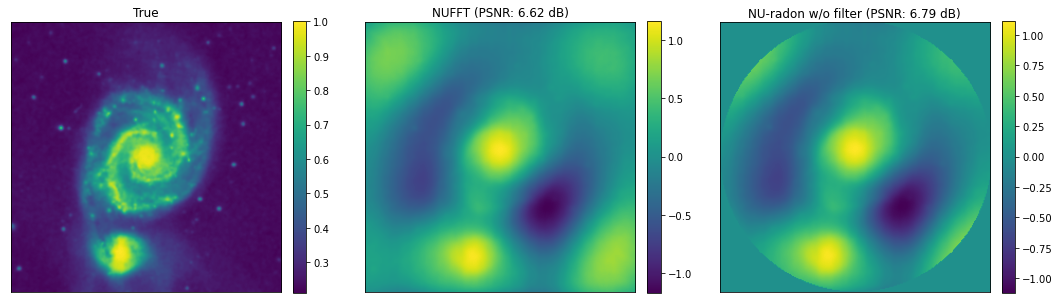

In [86]:
y1 = op.adj_op(y.reshape(1,-1)).real
y2 = adjoint(y, filter_name=None)[1].real[::-1]/512
compare([im, y1, y2], same_scale=False, colorbar=True, 
        titles=["True", f"NUFFT (PSNR: {peak_signal_noise_ratio(im*circle_mask, y1*circle_mask):.2f} dB)", f"NU-radon w/o filter (PSNR: {peak_signal_noise_ratio(im*circle_mask, y2):.2f} dB)"])

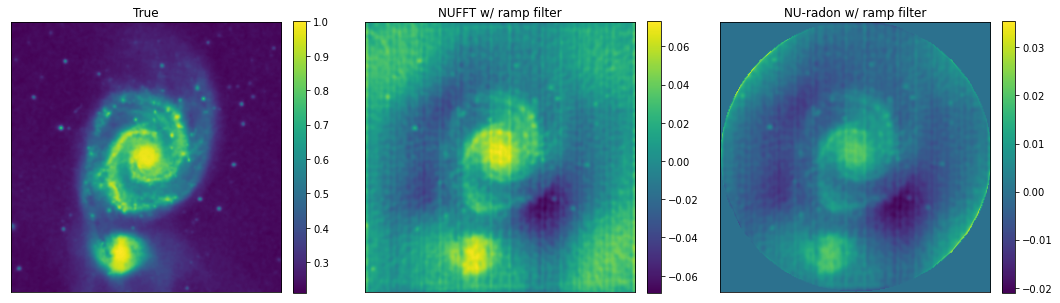

In [55]:
compare([im, op.adj_op(y.reshape(1,-1)*np.linalg.norm(uv, axis=1)).real, adjoint(y, filter_name='ramp')[1].real[::-1]/512], same_scale=False, colorbar=True, titles=["True", "NUFFT w/ ramp filter", "NU-radon w/ ramp filter"])

In [57]:
grid_cell = 2*np.pi /512 
binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(uv.shape[0])
for cell in list(cells):
    mask = np.all(np.array(cell) ==  binned, axis=1)
    w_gridded[mask] = np.sum(mask) #np.sum( (w_natural[mask])**2 ) /np.sum(mask)
# counts = [np.sum(x_c == cell) for cell in list(cells)]
w_grid = 1/w_gridded

In [72]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [59]:
w_ramp = np.linalg.norm(uv, axis=1)
w_ramp /= w_ramp.max()

In [66]:
y_ramp = op.adj_op(y.reshape(1,-1)*w_ramp).real
y_grid = op.adj_op(y.reshape(1,-1)*w_grid).real
y_radon = adjoint(y, filter_name='ramp')[1].real[::-1]/512

/tmp/ipykernel_129119/922425297.py:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  f"NUFFT w/ density filter (PSNR: {peak_signal_noise_ratio(im, y_grid):.2f} dB)",
/tmp/ipykernel_129119/922425297.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  f"NUFFT w/ ramp filter (PSNR: {peak_signal_noise_ratio(im, y_ramp):.2f} dB)",
/tmp/ipykernel_129119/922425297.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  f"NU-radon w/ ramp filter (PSNR: {peak_signal_noise_ratio(im*circle_mask, y_radon):.2f} dB)"


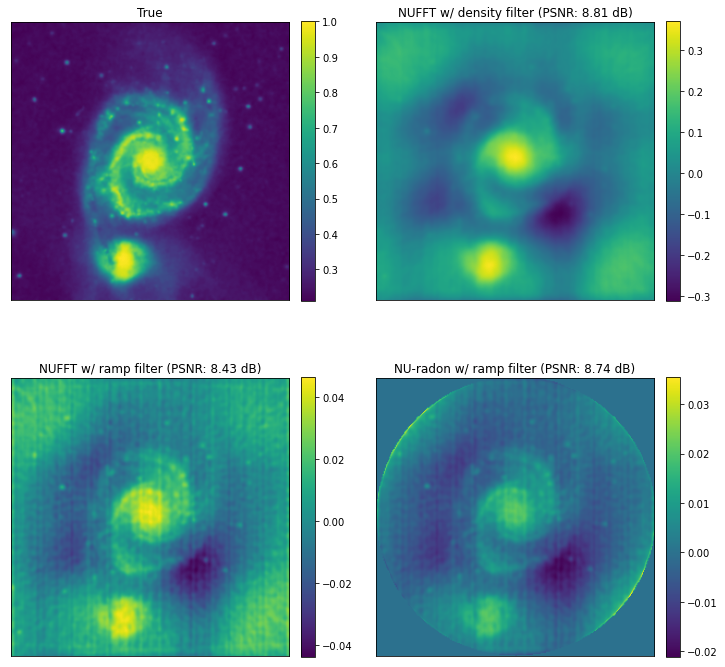

In [80]:
compare([
        im, 
        y_grid, 
        y_ramp,
        y_radon
    ], 
    nrows=2, ncols=2,
    same_scale=False, colorbar=True, 
    titles=[
        "True", 
        f"NUFFT w/ density filter (PSNR: {peak_signal_noise_ratio(im, y_grid):.2f} dB)", 
        f"NUFFT w/ ramp filter (PSNR: {peak_signal_noise_ratio(im, y_ramp):.2f} dB)", 
        f"NU-radon w/ ramp filter (PSNR: {peak_signal_noise_ratio(im*circle_mask, y_radon):.2f} dB)"
    ])

In [ ]:
(rec2[::-1].real/ op.adj_op(y.reshape(-1)).real)[127, 128]

In [ ]:
plt.imshow(m51)
plt.colorbar()

In [ ]:
21.6/256

In [ ]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*N)**2

In [ ]:
x_dirty_ndft = dft2(np.arange(-128,128), np.arange(-128,128), uv, y.reshape(-1))

In [ ]:
compare([x_dirty_ndft.real*Nd[0]*2, op.adj_op(y.reshape(1,-1)).real, adjoint(y, filter_name='ramp')[1].real[::-1]], same_scale=False)

In [ ]:
r1 = x_dirty_ndft.real*Nd[0]*2 - op.adj_op(y.reshape(1,-1)).real
r2 = x_dirty_ndft.real*Nd[0]*2  - adjoint(y, filter_name=None)[1].real[::-1]

In [ ]:
f'{np.sqrt(np.mean((r1*circle_mask)**2)):.4e}'

In [ ]:
f'{np.sqrt(np.mean((r2*circle_mask)**2)):.4e}'